In [1]:
import os
import cv2
import torch
import numpy as np
from PIL import Image, ImageDraw
from datetime import datetime
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
from diffusers import FluxKontextPipeline
from diffusers.utils import load_image

from nunchaku import NunchakuFluxTransformer2dModel
from nunchaku.utils import get_precision
# pytorch2.4.0 py3.10_cuda11.8_cudnn9.1.0_0
# https://github.com/nunchaku-tech/nunchaku/releases/tag/v0.3.1

In [2]:
torch.cuda.empty_cache()
transformer = NunchakuFluxTransformer2dModel.from_pretrained(
    f"mit-han-lab/nunchaku-flux.1-kontext-dev/svdq-{get_precision()}_r32-flux.1-kontext-dev.safetensors",
    local_files_only=True
)

pipe = FluxKontextPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-Kontext-dev", transformer=transformer, torch_dtype=torch.bfloat16
).to("cuda")
# pipe.enable_model_cpu_offload()


[2025-07-23 11:50:19.591] [info] Initializing QuantizedFluxModel on device 0
[2025-07-23 11:50:19.667] [info] Loading partial weights from pytorch
Injecting quantized module
[2025-07-23 11:50:23.591] [info] Done.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def create_output_folder(output_dir):
    local_tz = ZoneInfo('Europe/Berlin')
    local_time = datetime.now().astimezone(local_tz)
    time = local_time.strftime("%d-%b_%H:%M")
    folder_name = os.path.join(
        output_dir,
        f"{time}"
    )
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name


def concatenate_images(images, direction="horizontal"):
    """
    https://huggingface.co/spaces/kontext-community/FLUX.1-Kontext-multi-image
    """
    if  isinstance(images, Image.Image):
        return images.convert("RGB")
    
    if len(set((img.width, img.height) for img in images)) > 1:
        max_width = max(img.width for img in images)
        max_height = max(img.height for img in images)
        
        images = [img.convert("RGB").resize((max_width, max_height), Image.Resampling.LANCZOS) for img in images]
    
    if direction == "horizontal":
        total_width = sum(img.width for img in images)
        max_height = max(img.height for img in images)
        
        concatenated = Image.new('RGB', (total_width, max_height), (255, 255, 255))
        
        x_offset = 0
        for img in images:
            concatenated.paste(img, (x_offset, 0))
            x_offset += img.width
            
    else:  # vertical
        max_width = max(img.width for img in images)
        total_height = sum(img.height for img in images)
        
        concatenated = Image.new('RGB', (max_width, total_height), (255, 255, 255))
        
        y_offset = 0
        for img in images:
            concatenated.paste(img, (0, y_offset))
            y_offset += img.height
    
    return concatenated

def compare_images_and_mark(images):
    """
    Compare two images, calculate their interpolation, and mark differences with red translucent rectangles.
    """
    if len(images) == 1:
        raise ValueError("Exactly two images are required for comparison.")
    
    base_image = images[0]
    current_image = images[1]
    base_image_np = np.array(base_image)
    current_image_np = np.array(current_image)
    
    if base_image_np.shape != current_image_np.shape:
        raise ValueError("Both images must have the same dimensions.")
    
    diff = cv2.absdiff(base_image_np, current_image_np)
    
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, diff_mask = cv2.threshold(gray_diff, 30, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(diff_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    marked_image = Image.fromarray(base_image_np)
    draw = ImageDraw.Draw(marked_image, "RGBA")
    
    overlay = Image.new("RGBA", marked_image.size, (255, 255, 255, 0))
    overlay_draw = ImageDraw.Draw(overlay)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            x, y, w, h = cv2.boundingRect(contour)
            overlay_draw.rectangle([x, y, x + w, y + h], fill=(255, 0, 0, 50))

    marked_image = Image.alpha_composite(marked_image.convert("RGBA"), overlay)
    
    return [marked_image, images[1]]

In [14]:
image_dir = "/home/qianru/Projects/TUM/TUM_4/GR/code/seva_dn_splatter/dn-splatter/tests/input/FLUX_Inputs"
# input_images = [Image.open(os.path.join(image_dir, subdir, filename)) for subdir, filename in [('mod', 'ref.png'), ('unmod', '0.png'), ('unmod', 'ref.png')]]
input_images = [Image.open(os.path.join(image_dir, filename)) for filename in os.listdir(image_dir) if filename.endswith('.png') or filename.endswith('.jpg')]
input_images = [input_images[1], input_images[0]]
# input_images = compare_images_and_mark(input_images)
concatenate_image = concatenate_images(input_images, direction="horizontal")
smaller_image = concatenate_image.resize((int(concatenate_image.width * 0.5), int(concatenate_image.height * 0.5)))
smaller_image.show()
output_dir = "/home/qianru/Projects/TUM/TUM_4/GR/code/seva_dn_splatter/dn-splatter/tests/output"
prompt = "embed the first image with the second image"
# prompt = "Apply the difference in the red area from the first to the second image, and remove the first image, and keep the second image composition."
# prompt = "Add the component in the red square and remove the first image, and keep the original composition."
# prompt = "Paint the car according to BMW race car color."


(eog:10020): Gtk-WARNING **: 13:52:44.273: cannot open display: 


  0%|          | 0/28 [00:00<?, ?it/s]

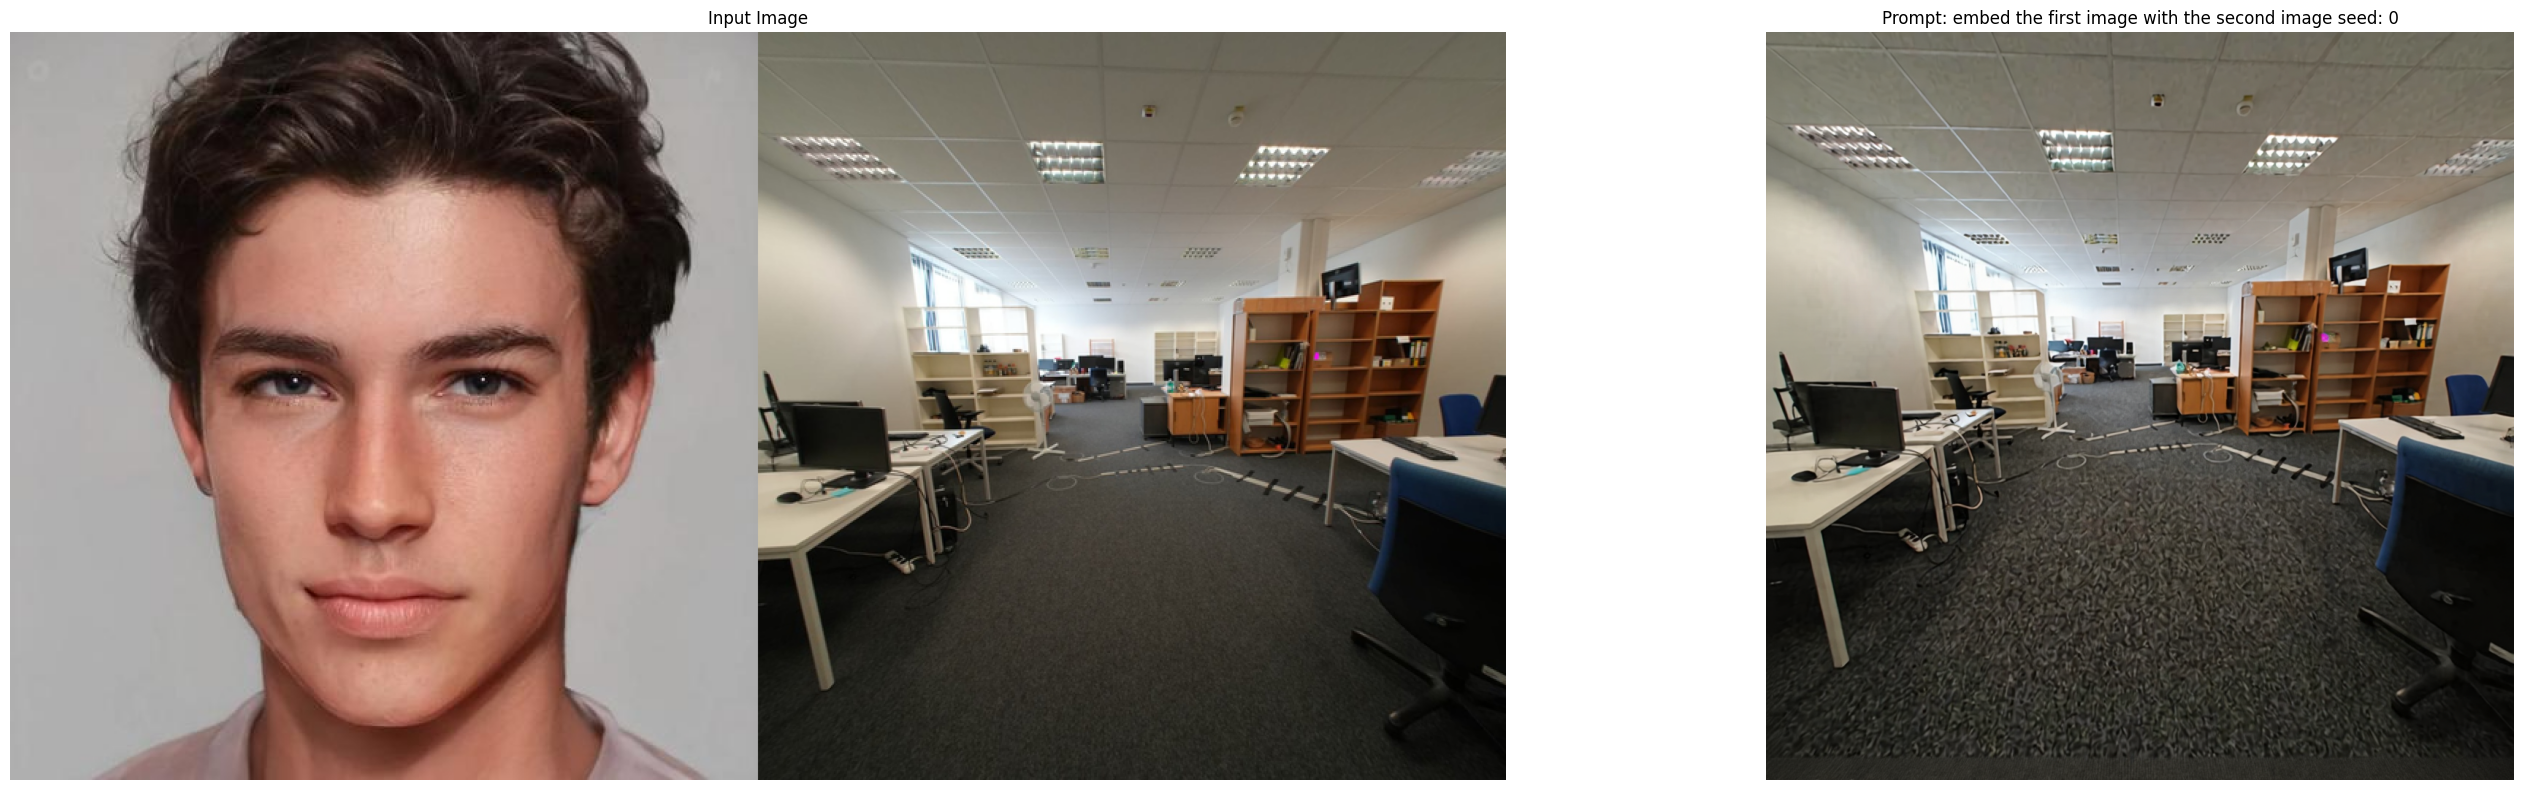

In [15]:
output_folder = create_output_folder(output_dir)
seed = 0
image = pipe(
  image=concatenate_image,
  prompt=prompt,
  guidance_scale=2.5,
  height=1024,
  width=1024,
  num_inference_steps=28,
  generator=torch.Generator(device="cuda").manual_seed(seed), # 82394757
).images[0]

image.save(output_folder + "/output_image.png")
concatenate_image.save(output_folder + "/input_image.png")

fig, axes = plt.subplots(1, 2, figsize=(30, 8))

axes[0].imshow(concatenate_image)
axes[0].axis("off")
axes[0].set_title("Input Image")

axes[1].imshow(image)
axes[1].axis("off")
axes[1].set_title(f"Prompt: {prompt} seed: {seed}")

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "comparison.png"), dpi=200)
plt.show()

torch.cuda.empty_cache()